In [1]:
import numpy as np
import autograd.numpy as npa
import matplotlib as mpl
mpl.rcParams['figure.dpi']=100
import matplotlib.pylab as plt
from autograd.scipy.signal import convolve as conv
from skimage.draw import circle
import ceviche
from ceviche import fdfd_ez, jacobian, fdfd_hz
from ceviche.optimizers import adam_optimize
from ceviche.modes import insert_mode
import collections
from make_gif import make_gif
# Create a container for our slice coords to be used for sources and probes
Slice = collections.namedtuple('Slice', 'x y')

In [2]:
#----------------- Simulation Constants -----------------#
# The angular frequencies
omega1=2*np.pi*200e12
# Wavevector
k0=omega1/299792458
# Spatial resolution in meters
dl=40e-9
# Number of pixels in x-direction
Nx=240
# Number of pixels in y-direction
Ny=240
# Number of pixels in the PMLs in each direction
Npml=40
# Minimum value of the relative permittivity
epsr_train_min=-6.0
epsr_train_max=1.0
# Maximum value of the relative permittivity
epsr_design=1.0
epsr_bckgd=12.0

#------------------- Domain Constants -------------------#
# Space between the PMLs and the design region (in pixels)
space=20
# Width of the waveguide (in pixels)
wg_width=24
# Length in pixels of the source/probe slices on each side of the center point
space_slice=16
# Number of dots in a row/column
num_dots=6
# Radius of dots
circle_rad=int((Nx-2*(Npml+space))/(2*num_dots))
# Lattice constant
ra=1

#---------------- Optimization Constants ----------------#
# Number of epochs in the optimization 
Nsteps=200
# Step size for the Adam optimizer
step_size=1e-4

#------------------ Graphing Constants ------------------#
Emax=0
emin=-6
emax=1

In [3]:
def init_design(epsrs, Nx=Nx, Ny=Ny, Npml=Npml, space=space, num_dots=num_dots, circle_rad=circle_rad, ra=ra):
    # Selector for each plasma rod
    rods = [np.zeros((Nx, Ny)) for i in range(num_dots**2)]
    # Selector for entire design region
    design_region = np.zeros((Nx, Ny))
    design_region[Npml+space:Nx-Npml-space, Npml+space:Ny-Npml-space] = 1
    
    # Initialize selector for circular plasma rods
    center_x = Npml+space+circle_rad
    for i in range(num_dots):
        center_y = Npml+space+circle_rad
        for j in range(num_dots):
            r, c = circle(center_x, center_y, circle_rad*ra)
            rods[j + i*num_dots][r, c] = 1
            center_y = center_y + 2*circle_rad
        center_x = center_x + 2*circle_rad
        
    return rods, design_region
    
def init_guides(Nx=Nx, Ny=Ny, Npml=Npml, space=space, wg_width=wg_width, space_slice=space_slice, wg_shift=9):
    """Initializes waveguides and sources

    space       : The space between the PML and the structure
    wg_width    : The feed and probe waveguide width
    space_slice : The added space for the probe and source slices
    """
    bg_rho = np.zeros((Nx, Ny))
        
    # Data waveguide 1
    bg_rho[0:int(Npml+space),Ny//2-wg_width//2:Ny//2+wg_width//2] = 1
    # Data probe slice 
    data_slice = Slice(x=np.array(Npml+1),
                        y=np.arange(Ny//2-wg_width//2-space_slice, Ny//2+wg_width//2+space_slice))
    input_slices = [data_slice]
    
    # Output waveguide
    bg_rho[int(Nx-Npml-space)::,Ny//2-wg_width//2:Ny//2+wg_width//2] = 1
    # Ground waveguide
    bg_rho[Nx//2-wg_width//2:Nx//2+wg_width//2,int(Ny-Npml-space)::] = 1
    
    # Output probe slice
    output_slice = Slice(x=np.array(Nx-Npml-1),
                         y=np.arange(Ny//2-wg_width//2-space_slice, Ny//2+wg_width//2+space_slice))
    #Ground probe slice
    ground_slice = Slice(x=np.arange(Ny//2-wg_width//2-space_slice, Ny//2+wg_width//2+space_slice),
                         y=np.array(Ny-Npml-1))
    output_slices = [output_slice, ground_slice]
            
    return bg_rho, input_slices, output_slices

def init_domain(epsrs):
    rods, design_region = init_design(epsrs)
    bg_rho, input_slices, output_slices = \
        init_guides(Nx, Ny, Npml, space=space, wg_width=wg_width, space_slice=space_slice, wg_shift=18)
    return bg_rho, design_region, rods, input_slices, output_slices

In [4]:
# set the colormap and centre the colorbar
class MidpointNormalize(mpl.colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))
    
def real(val, outline=None, ax=None, cbar=False, cmap='RdBu', outline_alpha=0.5, vmin=None, vmax=None):
    """Plots the real part of 'val', optionally overlaying an outline of 'outline'
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, constrained_layout=True)
    
    if vmin is None:
        vmax = np.real(val).max()
        vmin = np.real(val).min()
    h = ax.imshow(np.real(val.T), cmap=cmap, origin='lower left', clim=(vmin, vmax), \
                  norm=MidpointNormalize(midpoint=0,vmin=vmin,vmax=vmax))
    
    if outline is not None:
        ax.contour(outline.T, 0, colors='k', alpha=outline_alpha)
    
    if cbar:
        cbar = plt.colorbar(h, ax=ax)
        cbar.set_ticks([-6, 0, 1])
        cbar.set_ticklabels(['-6', '0', '1'])
        cbar.ax.set_ylabel('Relative Permittivity')
    
    return ax

def abslt(val, outline=None, ax=None, cbar=False, cmap='magma', outline_alpha=0.5, outline_val=None, vmax=None):
    """Plots the absolute value of 'val', optionally overlaying an outline of 'outline'
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, constrained_layout=True)      
    
    if vmax is None:
        vmax = np.abs(val).max()
    h = ax.imshow(np.abs(val.T), cmap=cmap, origin='lower left', vmin=0, vmax=vmax)
    
    if outline_val is None and outline is not None: outline_val = 0.5*(outline.min()+outline.max())
    if outline is not None:
        ax.contour(outline.T, [outline_val], colors='w', alpha=outline_alpha)

    if cbar:
        cbar = plt.colorbar(h, ax=ax)
        cbar.set_ticks([])
        cbar.ax.set_ylabel('Electric Field Strength')
    
    return ax

In [5]:
def viz_sim(epsr, data, slices=[], log=0):
    """Solve and visualize a simulation with permittivity 'epsr'
    """
    global emin, emax, Emax
    
    simulation = fdfd_hz(omega1, dl, epsr, [Npml, Npml])
    Ex, _, _ = simulation.solve(data)
    
    epsr_graph = np.array(epsr, copy=True)
    epsr_graph[Npml+space:Nx-Npml-space, Npml+space:Ny-Npml-space] = 0
    
    fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(16,4))
    abslt(Ex, outline=epsr_graph, ax=axs[0], cbar=True)
    real(epsr, ax=axs[1], cmap='RdGy', cbar=True, vmin=emin, vmax=emax)
    for sl in slices:
        for ax in axs:
            try:
                ax.plot(sl.x*np.ones(len(sl.y)), sl.y, 'w-', alpha=0.5)
            except:
                ax.plot(sl.x, sl.y*np.ones(len(sl.x)), 'w-', alpha=0.5)
        
    if log:
        if np.abs(Ex).max() > Emax:
            Emax=np.abs(Ex).max()
        np.savetxt('straight_tm/Ex_%03d.csv' % log, np.abs(Ex), delimiter=',')
        
        if epsr.min() < emin:
            emin=epsr.min()
        if epsr.max() > emax:
            emax=epsr.max()
        np.savetxt('straight_tm/epsr_%03d.csv' % log, epsr, delimiter=',')
    
    return (simulation, axs, fig)

def mask_combine_rho(rods, bg_rho, design_region):
    """Utility function for combining the design region rho and the background rho
    """
    train = (epsr_train_max-epsr_train_min)*rods*(rods!=0).astype(np.float) + epsr_train_min*(rods!=0).astype(np.float)
    print(train.min())
    design = epsr_design*design_region*(rods==0).astype(np.float)
    bckgd = epsr_bckgd*bg_rho*(design_region==0).astype(np.float)
    return train + design + bckgd

def scale_epsrs(epsrs, rods):
    epsrs = epsrs.flatten()
    epsrs = npa.arctan(epsrs) / np.pi + 0.5 
    rho = np.zeros(rods[0].shape)
    for i in range(len(epsrs)):
        rho += epsrs[i]*rods[i]
    return rho

def epsr_parameterization(epsrs, bg_rho, design_region, rods):
    """Defines the parameterization steps for constructing rho
    """
    rods = scale_epsrs(epsrs, rods)
    return mask_combine_rho(rods, bg_rho, design_region)

-2.5


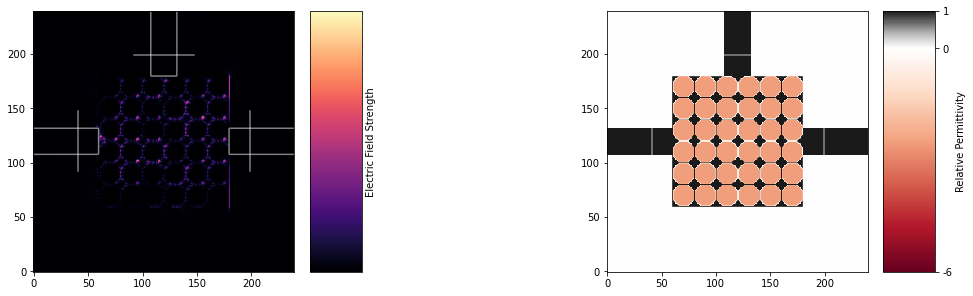

In [6]:
# Initialize the parametrization rho and the design region
epsrs = np.ones((num_dots, num_dots))*0
bg_rho, design_region, rods, input_slices, output_slices = init_domain(epsrs)

# Compute the permittivity from the design_region and the plasma rod permittivities
epsr_init = epsr_parameterization(epsrs, bg_rho, design_region, rods)

# Setup sources
data = insert_mode(omega1, dl, input_slices[0].x, input_slices[0].y, epsr_init, m=1)

# Setup probes
probe = insert_mode(omega1, dl, output_slices[0].x, output_slices[0].y, epsr_init, m=1)
ground = insert_mode(omega1, dl, output_slices[1].x, output_slices[1].y, epsr_init, m=1)

# Simulate initial device
simulation, ax, fig = viz_sim(epsr_init, data, slices = input_slices + output_slices)

In [7]:
def callback_output_structure(iteration, of_list, epsrs):
    """Callback function to output fields and the structures (for making sweet gifs)"""
    epsrs = epsrs.reshape((num_dots, num_dots))
    epsr = epsr_parameterization(epsrs, bg_rho, design_region, rods)
    _, axs, fig = viz_sim(epsr, data, slices = input_slices + output_slices, log=iteration)
    plt.close()

In [8]:
# Define optimization objective
def mode_overlap(E1, E2):
    """Defines an overlap integral between the sim field and desired field
    """
    return npa.abs(npa.sum(npa.conj(E1)*E2))*1e6

In [80]:
Ex_0, _, _ = simulation.solve(data)
normal = mode_overlap(Ex_0, probe)

def objective(epsrs):
    """Objective function called by optimizer
    1) Takes the density distribution as input
    2) Constructs epsr
    2) Runs the simulation
    3) Returns the overlap integral between the output wg field 
       and the desired mode field
    """
    epsrs = epsrs.reshape((num_dots, num_dots))
    epsr = epsr_parameterization(epsrs, bg_rho, design_region, rods)
    simulation.eps_r = epsr

    Ex, _, _ = simulation.solve(data)
    return mode_overlap(Ex, probe) / normal
    
def simulate():
    # Compute the gradient of the objective function using revere-mode differentiation
    objective_jac = jacobian(objective, mode='reverse')

    # Maximize the objective function using an ADAM optimizer
    epsrs_optimum, _ = adam_optimize(objective, epsrs.flatten(), objective_jac,
                            Nsteps=Nsteps, direction='max', step_size=step_size, callback=callback_output_structure)
    return epsrs_optimum.reshape((num_dots, num_dots))

Epoch:   1/200 | Duration: 2.45 secs | Value: 1.000000e+00
Epoch:   2/200 | Duration: 2.38 secs | Value: 1.668969e+00
Epoch:   3/200 | Duration: 2.40 secs | Value: 2.818542e+00
Epoch:   4/200 | Duration: 2.37 secs | Value: 1.899794e+00
Epoch:   5/200 | Duration: 2.58 secs | Value: 9.424594e+00
Epoch:   6/200 | Duration: 3.41 secs | Value: 2.664021e+00
Epoch:   7/200 | Duration: 2.53 secs | Value: 5.150707e+00
Epoch:   8/200 | Duration: 2.60 secs | Value: 5.630120e+00
Epoch:   9/200 | Duration: 2.30 secs | Value: 1.487922e+01
Epoch:  10/200 | Duration: 3.12 secs | Value: 1.185940e+01
Epoch:  11/200 | Duration: 3.69 secs | Value: 1.056511e+01
Epoch:  12/200 | Duration: 2.62 secs | Value: 1.068263e+01
Epoch:  13/200 | Duration: 2.24 secs | Value: 1.180953e+01
Epoch:  14/200 | Duration: 2.38 secs | Value: 1.394637e+01
Epoch:  15/200 | Duration: 2.34 secs | Value: 1.634188e+01
Epoch:  16/200 | Duration: 2.28 secs | Value: 1.328286e+01
Epoch:  17/200 | Duration: 2.39 secs | Value: 1.586279e+

Epoch: 140/200 | Duration: 2.38 secs | Value: 2.697922e+01
Epoch: 141/200 | Duration: 3.22 secs | Value: 2.696878e+01
Epoch: 142/200 | Duration: 2.35 secs | Value: 2.707256e+01
Epoch: 143/200 | Duration: 4.63 secs | Value: 2.708180e+01
Epoch: 144/200 | Duration: 5.89 secs | Value: 2.716030e+01
Epoch: 145/200 | Duration: 5.82 secs | Value: 2.719769e+01
Epoch: 146/200 | Duration: 6.40 secs | Value: 2.722285e+01
Epoch: 147/200 | Duration: 6.53 secs | Value: 2.732597e+01
Epoch: 148/200 | Duration: 6.62 secs | Value: 2.730808e+01
Epoch: 149/200 | Duration: 6.06 secs | Value: 2.739718e+01
Epoch: 150/200 | Duration: 6.19 secs | Value: 2.742774e+01
Epoch: 151/200 | Duration: 3.96 secs | Value: 2.740640e+01
Epoch: 152/200 | Duration: 4.23 secs | Value: 2.747256e+01
Epoch: 153/200 | Duration: 5.61 secs | Value: 2.754060e+01
Epoch: 154/200 | Duration: 4.16 secs | Value: 2.757196e+01
Epoch: 155/200 | Duration: 2.40 secs | Value: 2.757683e+01
Epoch: 156/200 | Duration: 2.50 secs | Value: 2.756177e+

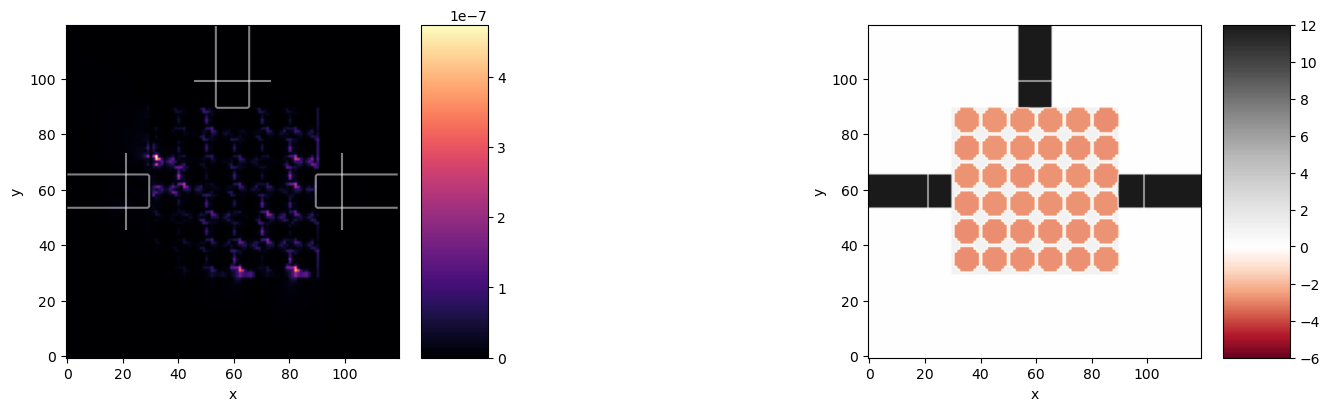

In [81]:
# Simulate optimal device
epsrs_optimum = simulate()
print(epsrs_optimum)
epsrs = epsr_parameterization(epsrs_optimum, bg_rho, design_region, rods)
_, ax, fig = viz_sim(epsrs, data, slices = input_slices + output_slices)

In [10]:
obj = []
mpl.rcParams.update({'font.size': 20})
for i in range(490, 500):
    Ex = np.loadtxt('bent_tm/Ex_%03d.csv' % i, delimiter=',')
    epsr = np.loadtxt('bent_tm/epsr_%03d.csv' % i, delimiter=',')
#     if i == 1:
#         normal = mode_overlap(Ex, ground)
#     obj.append(mode_overlap(Ex, ground) / normal)
    
    fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(8,4))
    epsr_graph = np.array(epsr, copy=True)
    epsr_graph[Npml+space:Nx-Npml-space, Npml+space:Ny-Npml-space] = 0
    
    for ax in axs:
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_yticks([])
        ax.set_xticks([])
#     for ax in axs[1][0:2]:
#         ax.set_xlabel('Epoch')
#         ax.set_ylabel('Percent Change in Objective')
    
    abslt(Ex, outline=epsr_graph, ax=axs[0], cbar=True, vmax=5e-8)
#     axs[1][0].plot(obj)
    real(epsr, ax=axs[1], cmap='RdGy', cbar=True, vmin=-6, vmax=1)
#     axs[-1][-1].axis('off')
    plt.savefig('bent_tm/normalized_%03d.png' % i, dpi=70)
    plt.close()

In [21]:
make_gif('bent_tm.gif', 500, 'bent_tm')